In [1]:
%load_ext autoreload
%autoreload 2

import sklearn
from sklearn import datasets

In [2]:
iris = datasets.load_iris()

In [3]:
iris

{'DESCR': '.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n                \n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n    ===========

In [4]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [5]:
print(iris.data.shape, iris.data.dtype)

(150, 4) float64


In [6]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [7]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [8]:
import numpy as np
from chainer_chemistry.datasets.numpy_tuple_dataset import NumpyTupleDataset

# All dataset is to train for simplicity
dataset = NumpyTupleDataset(iris.data.astype(np.float32), iris.target.astype(np.int32))
train = dataset

C:\Users\nakago\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
from chainer.functions import relu, dropout

from chainer_chemistry.models.mlp import MLP
from chainer_chemistry.models.prediction.classifier import Classifier


from chainer.functions import dropout
def activation_relu_dropout(h):
    return dropout(relu(h), ratio=0.5)


out_dim = len(iris.target_names)
predictor = MLP(out_dim=out_dim, hidden_dim=48, n_layers=2, activation=activation_relu_dropout)
classifier = Classifier(predictor)

In [10]:
from chainer import iterators
from chainer import optimizers
from chainer import training
from chainer.training import extensions as E


def fit(model, dataset, batchsize=16, epoch=10, out='results/tmp', device=-1):
    train_iter = iterators.SerialIterator(train, batchsize)
    optimizer = optimizers.Adam()
    optimizer.setup(model)

    updater = training.StandardUpdater(
        train_iter, optimizer, device=device)
    trainer = training.Trainer(updater, (epoch, 'epoch'), out=out)

    #trainer.extend(E.Evaluator(val_iter, classifier,
    #                           device=device, converter=concat_mols))
    trainer.extend(E.LogReport(), trigger=(10, 'epoch'))

    trainer.extend(E.PrintReport([
        'epoch', 'main/loss', 'main/accuracy', 'validation/main/loss',
        'validation/main/accuracy', 'elapsed_time']))
    trainer.run()

In [11]:
fit(classifier, train, batchsize=16, epoch=100)

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
10          0.829222    0.625                                                          0.284298      
20          0.808287    0.5625                                                         0.610615      
30          0.435911    0.8125                                                         1.16335       
40          0.360421    0.9375                                                         1.68585       
50          0.339677    0.9375                                                         2.32392       
60          0.405774    0.8125                                                         3.05227       
70          0.271674    0.9375                                                         3.63845       
80          0.334459    0.875                                                          4.29602       
90          0.294407    0.875                                                       

## Saliency visualization

In [12]:
from chainer_chemistry.saliency.calculator.gradient_calculator import GradientCalculator
from chainer_chemistry.saliency.calculator.integrated_gradients_calculator import IntegratedGradientsCalculator
from chainer_chemistry.link_hooks.variable_monitor_link_hook import VariableMonitorLinkHook


# 1. instantiation
gradient_calculator = GradientCalculator(classifier)
#gradient_calculator = IntegratedGradientsCalculator(classifier, steps=3,



In [14]:
from chainer_chemistry.saliency.calculator.calculator_utils import GaussianNoiseSampler

# --- VanillaGrad ---
M = 30
# 2. compute
saliency_samples_vanilla = gradient_calculator.compute(
    train, M=1,)
saliency_samples_smooth = gradient_calculator.compute(
    train, M=M, noise_sampler=GaussianNoiseSampler())
saliency_samples_bayes = gradient_calculator.compute(
    train, M=M, train=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.75it/s]


In [15]:
# 3. aggregate
method = 'square'
saliency_vanilla = gradient_calculator.aggregate(
    saliency_samples_vanilla, ch_axis=None, method=method)
saliency_smooth = gradient_calculator.aggregate(
    saliency_samples_smooth, ch_axis=None, method=method)
saliency_bayes = gradient_calculator.aggregate(
    saliency_samples_bayes, ch_axis=None, method=method)

In [17]:
from chainer_chemistry.saliency.visualizer.table_visualizer import TableVisualizer
from chainer_chemistry.saliency.visualizer.visualizer_utils import normalize_scaler


visualizer = TableVisualizer()

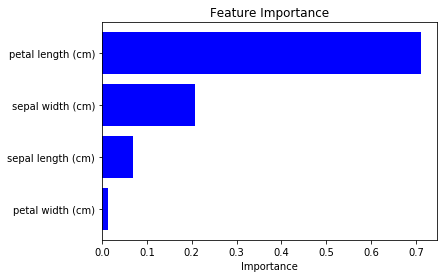

In [18]:
# Visualize saliency of `i`-th data
i = 0
visualizer.visualize(saliency_vanilla[i], feature_names=iris.feature_names,
                     scaler=normalize_scaler)

visualize saliency of all data --> this can be considered as "feature importance"

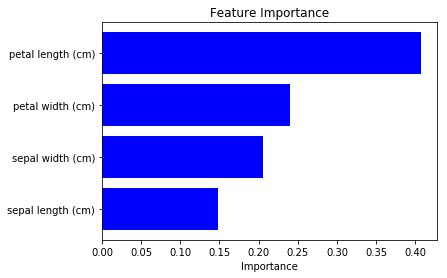

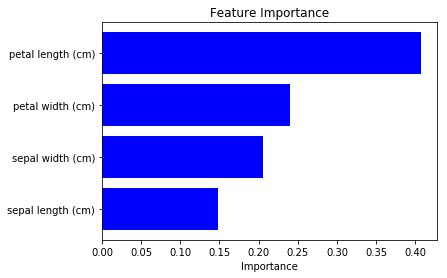

In [19]:
saliency_mean = np.mean(saliency_vanilla, axis=0)
visualizer.visualize(saliency_mean, feature_names=iris.feature_names, num_visualize=-1,
                    scaler=normalize_scaler)
visualizer.visualize(saliency_mean, feature_names=iris.feature_names, num_visualize=-1,
                    scaler=normalize_scaler, save_filepath='results/iris_vanilla_{}.png'.format(method))

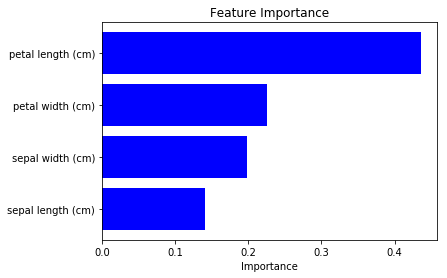

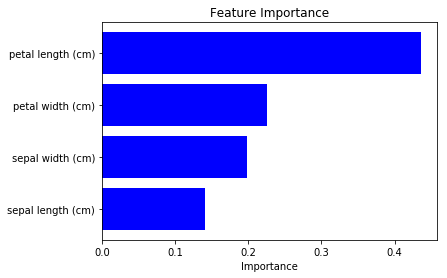

In [20]:
saliency_mean = np.mean(saliency_smooth, axis=0)
visualizer.visualize(saliency_mean, feature_names=iris.feature_names, num_visualize=-1,
                    scaler=normalize_scaler)
visualizer.visualize(saliency_mean, feature_names=iris.feature_names, num_visualize=-1,
                    scaler=normalize_scaler, save_filepath='results/iris_smooth_{}.png'.format(method))

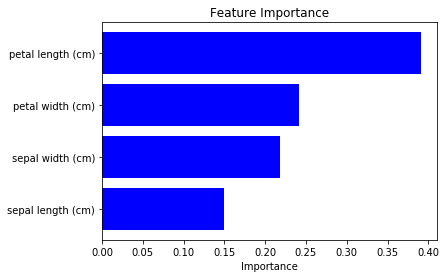

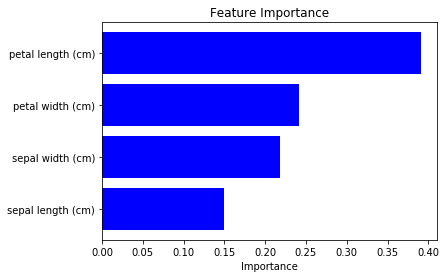

In [21]:
saliency_mean = np.mean(saliency_bayes, axis=0)
visualizer.visualize(saliency_mean, feature_names=iris.feature_names, num_visualize=-1,
                    scaler=normalize_scaler)
visualizer.visualize(saliency_mean, feature_names=iris.feature_names, num_visualize=-1,
                    scaler=normalize_scaler, save_filepath='results/iris_bayes_{}.png'.format(method))

## sklearn random forest feature importance

Ref:
 - https://qiita.com/TomokIshii/items/290adc16e2ca5032ca07
 - https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python

In [22]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0)

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)

accu = accuracy_score(y_test, y_pred)
print('accuracy = {:>.4f}'.format(accu))

# Feature Importance
fti = clf_rf.feature_importances_   

print('Feature Importances:')
for i, feat in enumerate(iris['feature_names']):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

C:\Users\nakago\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy = 0.9667
Feature Importances:
	sepal length (cm)    : 0.062307
	sepal width (cm)     : 0.007475
	petal length (cm)    : 0.461299
	petal width (cm)     : 0.468920


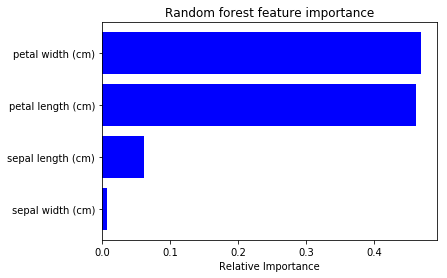

In [23]:
import matplotlib.pyplot as plt

features = iris['feature_names']
importances = clf_rf.feature_importances_
indices = np.argsort(importances)

plt.title('Random forest feature importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()